In [3]:
import torch
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision.transforms import v2

In [4]:
images = np.load('data/mds-misis-dl-captchan/images.npy')
labels = np.load('data/mds-misis-dl-captchan/labels.npy')

In [5]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)

In [57]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, mode='train'):
        super().__init__()
        self.images = images
        self.labels = labels
        self.mode = mode
        self.transforms = v2.Compose([
                            v2.ToImage(),
                            # v2.RandomHorizontalFlip(p=0.5),
                            v2.RandomRotation(degrees=(-30, 30)),
                            v2.ColorJitter(brightness=.5, hue=.3),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

        self.val_transforms = v2.Compose([
                            v2.ToImage(),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'test':
            img = self.images[idx]
            return self.val_transforms(img)
        elif self.mode == 'val':
            img = self.images[idx]
            return self.val_transforms(img), torch.tensor(self.labels[idx])
        else:
            img = self.images[idx]
            return self.transforms(img), torch.tensor(self.labels[idx])

In [58]:
train_dataset = CustomDataset(train_images, train_labels, 'train')
val_dataset = CustomDataset(val_images, val_labels, 'val')

In [59]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=2)

In [60]:
device = torch.device('cuda:0')

In [61]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(256, 26)
).to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 30

In [62]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

max_acc = 0.

for epoch in range(num_epochs):
    train_epoch_losses = []
    val_epoch_losses = []
    train_epoch_accuracies = []
    val_epoch_accuracies = []

    model.train()
    print(f'Epoch: {epoch}')
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)

        assert not np.isnan(loss.item())
        loss.backward()
        opt.step()
        train_epoch_losses.append(loss.item())
        train_epoch_accuracies.append(accuracy_score(y.detach().cpu().numpy(), preds.argmax(dim=1).detach().cpu().numpy()))


    model.eval()
    for x, y in tqdm(val_dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = loss_fn(preds, y)
        val_epoch_losses.append(loss.item())
        val_epoch_accuracies.append(accuracy_score(y.detach().cpu().numpy(), preds.argmax(dim=1).detach().cpu().numpy()))

    train_losses.append(np.mean(train_epoch_losses))
    val_losses.append(np.mean(val_epoch_losses))
    train_accuracies.append(np.mean(train_epoch_accuracies))
    val_accuracies.append(np.mean(val_epoch_accuracies))

    if val_accuracies[-1] > max_acc:
        max_acc = val_accuracies[-1]
        torch.save(model, 'model.pt')
        print(f'Saved model with {max_acc} accuracy')

    print(f'Epoch: {epoch+1} Train acc: {train_accuracies[-1]} Val acc: {val_accuracies[-1]}')

Epoch: 0


100%|██████████| 125/125 [00:00<00:00, 138.91it/s]


Saved model with 0.438 accuracy
Epoch: 1 Train acc: 0.12466666666666666 Val acc: 0.438
Epoch: 1


100%|██████████| 125/125 [00:01<00:00, 116.39it/s]


Saved model with 0.722 accuracy
Epoch: 2 Train acc: 0.509 Val acc: 0.722
Epoch: 2


100%|██████████| 125/125 [00:00<00:00, 138.31it/s]


Saved model with 0.78 accuracy
Epoch: 3 Train acc: 0.6465 Val acc: 0.78
Epoch: 3


100%|██████████| 125/125 [00:00<00:00, 140.11it/s]


Saved model with 0.82 accuracy
Epoch: 4 Train acc: 0.7056666666666667 Val acc: 0.82
Epoch: 4


100%|██████████| 125/125 [00:01<00:00, 87.01it/s] 


Saved model with 0.8375 accuracy
Epoch: 5 Train acc: 0.7399444444444444 Val acc: 0.8375
Epoch: 5


100%|██████████| 125/125 [00:00<00:00, 140.73it/s]


Saved model with 0.85 accuracy
Epoch: 6 Train acc: 0.7588333333333334 Val acc: 0.85
Epoch: 6


100%|██████████| 125/125 [00:00<00:00, 142.49it/s]


Saved model with 0.8665 accuracy
Epoch: 7 Train acc: 0.7757222222222222 Val acc: 0.8665
Epoch: 7


100%|██████████| 125/125 [00:01<00:00, 120.79it/s]


Saved model with 0.8715 accuracy
Epoch: 8 Train acc: 0.7906666666666666 Val acc: 0.8715
Epoch: 8


100%|██████████| 125/125 [00:00<00:00, 144.23it/s]


Saved model with 0.8865 accuracy
Epoch: 9 Train acc: 0.8053888888888889 Val acc: 0.8865
Epoch: 9


100%|██████████| 125/125 [00:01<00:00, 116.10it/s]


Saved model with 0.891 accuracy
Epoch: 10 Train acc: 0.8159444444444445 Val acc: 0.891
Epoch: 10


100%|██████████| 125/125 [00:00<00:00, 136.03it/s]


Epoch: 11 Train acc: 0.8208333333333333 Val acc: 0.89
Epoch: 11


100%|██████████| 125/125 [00:00<00:00, 133.41it/s]


Saved model with 0.894 accuracy
Epoch: 12 Train acc: 0.8286666666666667 Val acc: 0.894
Epoch: 12


100%|██████████| 125/125 [00:01<00:00, 88.97it/s]


Saved model with 0.897 accuracy
Epoch: 13 Train acc: 0.8345 Val acc: 0.897
Epoch: 13


100%|██████████| 125/125 [00:00<00:00, 139.70it/s]


Saved model with 0.9 accuracy
Epoch: 14 Train acc: 0.8365555555555556 Val acc: 0.9
Epoch: 14


100%|██████████| 125/125 [00:00<00:00, 138.44it/s]


Epoch: 15 Train acc: 0.8455 Val acc: 0.8985
Epoch: 15


100%|██████████| 125/125 [00:00<00:00, 136.14it/s]


Epoch: 16 Train acc: 0.8471111111111111 Val acc: 0.8945
Epoch: 16


100%|██████████| 125/125 [00:00<00:00, 139.96it/s]


Saved model with 0.9115 accuracy
Epoch: 17 Train acc: 0.8502777777777778 Val acc: 0.9115
Epoch: 17


100%|██████████| 125/125 [00:01<00:00, 93.41it/s] 


Epoch: 18 Train acc: 0.8566111111111111 Val acc: 0.9045
Epoch: 18


100%|██████████| 125/125 [00:00<00:00, 140.07it/s]


Epoch: 19 Train acc: 0.8608333333333333 Val acc: 0.91
Epoch: 19


100%|██████████| 125/125 [00:00<00:00, 138.20it/s]


Saved model with 0.9125 accuracy
Epoch: 20 Train acc: 0.8626111111111111 Val acc: 0.9125
Epoch: 20


100%|██████████| 125/125 [00:00<00:00, 140.10it/s]


Epoch: 21 Train acc: 0.866 Val acc: 0.9085
Epoch: 21


100%|██████████| 125/125 [00:00<00:00, 135.50it/s]


Epoch: 22 Train acc: 0.8646111111111111 Val acc: 0.9075
Epoch: 22


100%|██████████| 125/125 [00:00<00:00, 129.17it/s]


Saved model with 0.9205 accuracy
Epoch: 23 Train acc: 0.8680555555555556 Val acc: 0.9205
Epoch: 23


100%|██████████| 125/125 [00:00<00:00, 136.90it/s]


Epoch: 24 Train acc: 0.8716666666666667 Val acc: 0.9165
Epoch: 24


100%|██████████| 125/125 [00:00<00:00, 139.54it/s]


Epoch: 25 Train acc: 0.8781666666666667 Val acc: 0.918
Epoch: 25


100%|██████████| 125/125 [00:01<00:00, 72.94it/s]


Epoch: 26 Train acc: 0.8748888888888889 Val acc: 0.915
Epoch: 26


100%|██████████| 125/125 [00:00<00:00, 140.59it/s]


Epoch: 27 Train acc: 0.8761666666666666 Val acc: 0.9175
Epoch: 27


100%|██████████| 125/125 [00:00<00:00, 137.31it/s]


Saved model with 0.923 accuracy
Epoch: 28 Train acc: 0.8805555555555555 Val acc: 0.923
Epoch: 28


100%|██████████| 125/125 [00:01<00:00, 90.66it/s] 


Epoch: 29 Train acc: 0.8848888888888888 Val acc: 0.916
Epoch: 29


100%|██████████| 125/125 [00:00<00:00, 134.83it/s]

Epoch: 30 Train acc: 0.8824444444444445 Val acc: 0.921


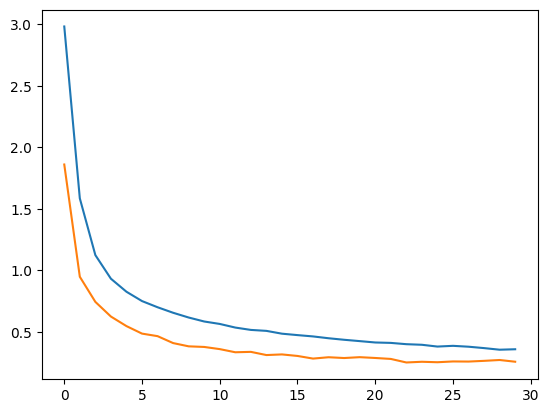

In [65]:
plt.plot(train_losses)
plt.plot(val_losses)

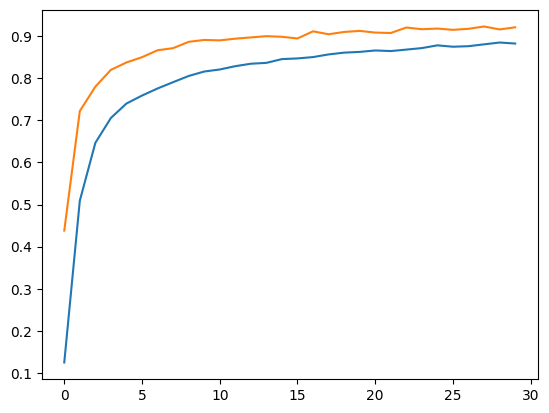

In [66]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)

In [70]:
model = torch.load('model.pt', weights_only=False).to(device)

In [71]:
reals, predicts = [], []

model.eval()
for x, y in tqdm(val_dataloader):
    x, y = x.to(device), y.to(device)
    preds = model(x)

    reals.extend(y.detach().cpu().numpy().tolist())
    predicts.extend(preds.argmax(dim=1).detach().cpu().numpy().tolist())

100%|██████████| 125/125 [00:00<00:00, 147.62it/s]


In [72]:
accuracy_score(reals, predicts)

0.923

In [73]:
test_images = np.load('data/mds-misis-dl-captchan/images_sub.npy')

In [74]:
test_dataset = CustomDataset(test_images, mode='test')

In [75]:
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=0)

In [76]:
submission = pd.read_csv('data/mds-misis-dl-captchan/sample_submission.csv')

In [77]:
predicts = []

model.eval()
for x in tqdm(test_dataloader):
    x = x.to(device)
    preds = model(x)
    predicts.extend(preds.argmax(dim=1).detach().cpu().numpy().tolist())

100%|██████████| 12500/12500 [00:30<00:00, 408.29it/s]


In [78]:
submission['Category'] = predicts

In [79]:
submission.to_csv('submission_VasilevNA_1.csv', index=False)